## ***preprocessing***


*   memuat file,

* membuang baris tanpa teks,

* membersihkan teks (lowercase, remove url/angka/punct),

* tokenisasi,

* stemming dengan Sastrawi,

* simpan hasil preprocessed.




In [2]:
# Cell 1: install deps (jalankan di Colab)
!pip install Sastrawi tqdm



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.8 MB/s eta 0:00:00


# *Import dan load dataset*

In [3]:
# Cell 2: import & load
import pandas as pd, re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from tqdm import tqdm
tqdm.pandas()

df = pd.read_csv('/content/dataset_review_gmaps.csv')  # upload file ke Colab terlebih dahulu
print("Shape awal:", df.shape)
print("Kolom:", df.columns.tolist())


Shape awal: (959, 6)
Kolom: ['title', 'url', 'stars', 'name', 'reviewUrl', 'text']


# *Exploratory Data Analysis sederhana*

In [4]:
# Jumlah total & missing text
print("Total rows:", len(df))
print("Jumlah text kosong:", df['text'].isna().sum())
print("Jumlah text terisi:", df['text'].notna().sum())

# Distribusi stars
print("\nDistribusi rating (stars):")
print(df['stars'].value_counts().sort_index())

# Tampilkan beberapa contoh teks
print("\nContoh beberapa teks (kolom 'text'):")
display(df['text'].dropna().sample(min(10, df['text'].dropna().shape[0]), random_state=42).reset_index(drop=True))


Total rows: 959
Jumlah text kosong: 644
Jumlah text terisi: 315

Distribusi rating (stars):
stars
1     22
2      8
3     35
4    124
5    770
Name: count, dtype: int64

Contoh beberapa teks (kolom 'text'):


,text
0,Upgris the best
1,Angkatan Th1991 FPBS bhs inggris
2,Tempat nya bagus teduh
3,Jos
4,Jos
5,"Bagus, ada gedung pertemuan yg luas"
6,Kampusku
7,Bagus
8,"Masjidnya tak ad wc,,"
9,The Meaning University


# *Ambil hanya baris yang ada teks (prasyarat preprocessing)*

In [5]:
# Kita fokus pada baris yang berisi text (ulasan)
df_text = df[df['text'].notna()].copy().reset_index(drop=True)
print("Rows with text:", df_text.shape[0])


Rows with text: 315


# *Preprocessing: clean, tokenisasi, stopwords, stemming*

In [6]:
# Preprocessing (cleaning + tokenizing + stemming Bahasa Indonesia)
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Stopword list sederhana (kamu bisa tambahkan kata lain sesuai kebutuhan)
STOPWORDS = set([
    'yang','dan','di','ke','dari','ini','itu','atau','pun','jika','karena','dengan','sebagai','pada','adalah','saya',
    'kamu','nya','untuk','akan','apa','tidak','ga','gak','yg','rt','dgn','jd','sih','ya','oh','adalah','si','kami',
    'anda','juga','tadi','itu','saja','lebih','cukup','lagi','lagi','ad','tdk'
])

def clean_text(s: str) -> str:
    s = str(s)
    s = s.lower()
    s = re.sub(r'http\S+',' ', s)     # remove urls
    s = re.sub(r'@\w+',' ', s)        # mentions
    s = re.sub(r'[^0-9a-z\s]', ' ', s) # keep alnum + spaces
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def tokenize_and_stem(s: str):
    s_clean = clean_text(s)
    toks = [t for t in s_clean.split() if t not in STOPWORDS]
    # lakukan stemming (Sastrawi)
    toks_stem = [stemmer.stem(t) for t in toks]
    return toks_stem

# terapkan
df_text['clean'] = df_text['text'].astype(str).progress_apply(clean_text)
df_text['tokens'] = df_text['text'].astype(str).progress_apply(tokenize_and_stem)

# tampil beberapa contoh hasil preprocessing
display(df_text[['text','clean','tokens']].head(8))


100%|██████████| 315/315 [01:02<00:00,  5.00it/s]


,text,clean,tokens
0,Kampus keren. Sayang sempit banget. Buat parki...,kampus keren sayang sempit banget buat parkir ...,"[kampus, keren, sayang, sempit, banget, buat, ..."
1,Kalian harus masup UPGRIS karena:\n1. SIOMAY D...,kalian harus masup upgris karena 1 siomay deke...,"[kalian, harus, masup, upgris, 1, siomay, deke..."
2,satpam malas tidak mau membantu mahasiswa untu...,satpam malas tidak mau membantu mahasiswa untu...,"[satpam, malas, mau, bantu, mahasiswa, keluar,..."
3,Terakreditasi UNGGUL di tahun 2025,terakreditasi unggul di tahun 2025,"[akreditasi, unggul, tahun, 2025]"
4,Dosen yg namanya Rasiman dan Widya kalo ngasih...,dosen yg namanya rasiman dan widya kalo ngasih...,"[dosen, nama, rasiman, widya, kalo, ngasih, ni..."
5,My first University,my first university,"[my, first, university]"
6,Kampus Terbaik🩵🩵💙,kampus terbaik,"[kampus, baik]"
7,Adem,adem,[adem]


# *Daftar keyword ABSC (lebih lengkap, sesuai permintaan)*

In [7]:
# Daftar keyword (belum distem) — akan distem supaya cocok dengan tokens
ASPECT_KEYWORDS_RAW = {
    'fasilitas_infrastruktur': [
        'gedung','ruang','kelas','ruangan','kampus','area','lingkungan','parkir','toilet','mushola','kantin','taman',
        'wifi','jaringan','fasilitas','sarana','prasarana','perpustakaan','lab','laboratorium','gedung baru','bersih',
        'rapi','luas','sempit','panas','sejuk','teduh','lapangan','kursi','meja','parkiran','halaman','kebersihan',
        'infrastruktur','proyektor','ac','acnya','ac rusak','wc'
    ],
    'pengalaman_universitas': [
        'dosen','mahasiswa','belajar','kuliah','pengajaran','pelayanan','ramah','staff','administrasi','jurusan','fakultas',
        'pengalaman','kegiatan','seminar','organisasi','akademik','alumni','ujian','praktek','tugas','perkuliahan',
        'suasana','lingkungan belajar','kegiatan kampus','teman','komunitas','motivasi','tenaga pengajar','pelayanan akademik',
        'penerimaan','registrasi','pembimbing','bimbingan','birokrasi','wira','lokal'
    ],
    'harga_akses': [
        'biaya','harga','murah','mahal','terjangkau','lokasi','strategis','transportasi','akses','dekat','jauh','jalan',
        'rute','kendaraan','macet','parkir','mudah dijangkau','angkot','bus','motor','mobil','tiket','ongkos','ongkir',
        'aksesibilitas','parkiran mahal'
    ]
}

# Stem keywords supaya cocok dengan tokens yang sudah di-stem
def stem_keyword_list(word_list):
    out = set()
    for w in word_list:
        # break multi-word -> stem per token
        parts = str(w).lower().split()
        stemmed_parts = [stemmer.stem(p) for p in parts if p not in STOPWORDS]
        if len(stemmed_parts) == 0:
            continue
        out.add(" ".join(stemmed_parts))
    return out

ASPECT_KEYWORDS = {k: stem_keyword_list(v) for k,v in ASPECT_KEYWORDS_RAW.items()}

# tampil ringkasan keyword (setelah stemming)
for a,kw in ASPECT_KEYWORDS.items():
    print(f"{a}: {len(kw)} keywords. Sample:", list(kw)[:12])


fasilitas_infrastruktur: 37 keywords. Sample: ['fasilitas', 'lingkung', 'acnya', 'kantin', 'halaman', 'jaring', 'wifi', 'ruang', 'proyektor', 'sejuk', 'gedung', 'rapi']
pengalaman_universitas: 33 keywords. Sample: ['dosen', 'uji', 'wira', 'seminar', 'bimbing', 'mahasiswa', 'giat', 'fakultas', 'administrasi', 'motivasi', 'terima', 'komunitas']
harga_akses: 26 keywords. Sample: ['tiket', 'angkot', 'mahal', 'aksesibilitas', 'macet', 'murah', 'motor', 'jangkau', 'mobil', 'rute', 'bus', 'jalan']


# *Sentiment lexicon (lebih lengkap) + negation handling*

In [8]:
# Lexicon kata positif/negatif (tambah sesuai observasi)
POS_WORDS_RAW = [
    'bagus','baik','nyaman','bersih','ramah','cepat','puas','rekomendasi','lengkap','terawat',
    'membantu','mudah','oke','mantap','bagus sekali','oke banget','keren','bagusnya','baguss'
]
NEG_WORDS_RAW = [
    'buruk','kotor','mahal','lambat','malas','jelek','tidak nyaman','tidaknyaman','mengecewakan','masalah',
    'rusak','susah','sulit','antri','repot','bising','macet','parah','jelek sekali','gagal','ringkih','burukk'
]

NEGATION_WORDS = set(['tidak','gak','nggak','bukan','tak'])

# Stem lexicon
POS_WORDS = set()
for w in POS_WORDS_RAW:
    parts = w.split()
    stemmed = " ".join([stemmer.stem(p) for p in parts if p not in STOPWORDS])
    POS_WORDS.add(stemmed)

NEG_WORDS = set()
for w in NEG_WORDS_RAW:
    parts = w.split()
    stemmed = " ".join([stemmer.stem(p) for p in parts if p not in STOPWORDS])
    NEG_WORDS.add(stemmed)

print("Sample POS words (stemmed):", list(POS_WORDS)[:10])
print("Sample NEG words (stemmed):", list(NEG_WORDS)[:10])


Sample POS words (stemmed): ['bantu', 'mudah', 'keren', 'ramah', 'nyaman', 'bersih', 'puas', 'lengkap', 'baik', 'bagus sekali']
Sample NEG words (stemmed): ['buruk', 'rusak', 'ringkih', 'mahal', 'macet', 'repot', 'kecewa', 'lambat', 'malas', 'antri']


# *Fungsi deteksi aspek & sentiment rule-based*

In [9]:
# Fungsi deteksi aspek (cocokkan kata kunci yang sudah distem)
def detect_aspects_from_tokens(tokens):
    s = set(tokens)
    found = []
    for aspect, kwset in ASPECT_KEYWORDS.items():
        # check any keyword in tokens; keyword bisa multi-token (gabungan) - kita check if all parts present in contiguous not necessary,
        # we do simple containment of any keyword tokens in the token set or phrase in joined string
        joined = " ".join(tokens)
        matched = False
        for kw in kwset:
            # jika keyword multi-word (mis. 'gedung baru'), cek apakah phrase muncul
            if " " in kw:
                if kw in joined:
                    matched = True
                    break
            else:
                if kw in s:
                    matched = True
                    break
        if matched:
            found.append(aspect)
    return found

# Fungsi sentiment sederhana berdasarkan lexicon + negasi
def sentiment_rule_from_tokens(tokens):
    pos = 0
    neg = 0
    for i,t in enumerate(tokens):
        # Check for multi-word lexicon by looking ahead a bit (max 3 tokens phrase)
        # Build small sliding phrases
        for L in (3,2,1):
            if i+L <= len(tokens):
                phrase = " ".join(tokens[i:i+L])
                if phrase in POS_WORDS:
                    # check previous token for negation
                    if i>0 and tokens[i-1] in NEGATION_WORDS:
                        neg += 1
                    else:
                        pos += 1
                if phrase in NEG_WORDS:
                    if i>0 and tokens[i-1] in NEGATION_WORDS:
                        pos += 1
                    else:
                        neg += 1
    if pos - neg >= 1:
        return 'positif'
    elif neg - pos >= 1:
        return 'negatif'
    else:
        return 'netral'


# *Terapkan deteksi aspek dan weak-labeling; juga buat label dari stars*

In [10]:
# Terapkan ke dataframe
df_text['aspects'] = df_text['tokens'].progress_apply(detect_aspects_from_tokens)
df_text['weak_label_text'] = df_text['tokens'].progress_apply(sentiment_rule_from_tokens)

# Buat label dari stars sebagai alternatif
def star_label(stars):
    if stars >= 4:
        return 'positif'
    elif stars == 3:
        return 'netral'
    else:
        return 'negatif'

df_text['weak_label_star'] = df_text['stars'].apply(star_label)

# Buat kolom agreement flag
df_text['label_agree_text_star'] = (df_text['weak_label_text'] == df_text['weak_label_star'])

# Buat label_final (rule sederhana, jelaskan di bawah)
# Rule yang dipakai:
# - Jika weak_label_text != 'netral' -> gunakan weak_label_text (lexicon) sebagai final (karena ini mengandalkan isi teks)
# - Jika weak_label_text == 'netral' tetapi weak_label_star != 'netral' -> gunakan weak_label_star
# - Jika keduanya netral -> netral
# - Tandai 'conflict' jika weak_label_text != weak_label_star
def combine_labels(row):
    lt = row['weak_label_text']
    ls = row['weak_label_star']
    if lt != 'netral':
        final = lt
    elif ls != 'netral':
        final = ls
    else:
        final = 'netral'
    conflict = (lt != ls)
    return pd.Series({'label_final': final, 'conflict_label': conflict})

df_text[['label_final','conflict_label']] = df_text.progress_apply(combine_labels, axis=1)

# Tampilkan ringkasan hasil
print("Distribusi label_final:")
print(df_text['label_final'].value_counts())
print("\nPersentase kesepakatan teks vs stars:", df_text['label_agree_text_star'].mean()*100, "%")
print("Jumlah kasus conflict (text vs star):", df_text['conflict_label'].sum())


100%|██████████| 315/315 [00:00<00:00, 2923.29it/s]

Distribusi label_final:
label_final
positif    289
negatif     14
netral      12
Name: count, dtype: int64

Persentase kesepakatan teks vs stars: 32.06349206349206 %
Jumlah kasus conflict (text vs star): 214


# *Simpan hasil preprocessed + ABSC ke CSV*

In [11]:
OUTFILE = 'dataset_review_gmaps_preprocessed_ABSC.csv'
df_text.to_csv(OUTFILE, index=False)
print("Saved preprocessed file to:", OUTFILE)
# Tampilkan beberapa baris akhir
display(df_text[['text','clean','tokens','aspects','weak_label_text','weak_label_star','label_final','conflict_label']].head(12))


Saved preprocessed file to: dataset_review_gmaps_preprocessed_ABSC.csv


,text,clean,tokens,aspects,weak_label_text,weak_label_star,label_final,conflict_label
0,Kampus keren. Sayang sempit banget. Buat parki...,kampus keren sayang sempit banget buat parkir ...,"[kampus, keren, sayang, sempit, banget, buat, ...","[fasilitas_infrastruktur, harga_akses]",netral,positif,positif,True
1,Kalian harus masup UPGRIS karena:\n1. SIOMAY D...,kalian harus masup upgris karena 1 siomay deke...,"[kalian, harus, masup, upgris, 1, siomay, deke...","[fasilitas_infrastruktur, pengalaman_universitas]",positif,positif,positif,False
2,satpam malas tidak mau membantu mahasiswa untu...,satpam malas tidak mau membantu mahasiswa untu...,"[satpam, malas, mau, bantu, mahasiswa, keluar,...","[pengalaman_universitas, harga_akses]",netral,negatif,negatif,True
3,Terakreditasi UNGGUL di tahun 2025,terakreditasi unggul di tahun 2025,"[akreditasi, unggul, tahun, 2025]",[],netral,positif,positif,True
4,Dosen yg namanya Rasiman dan Widya kalo ngasih...,dosen yg namanya rasiman dan widya kalo ngasih...,"[dosen, nama, rasiman, widya, kalo, ngasih, ni...",[pengalaman_universitas],netral,negatif,negatif,True
5,My first University,my first university,"[my, first, university]",[],netral,positif,positif,True
6,Kampus Terbaik🩵🩵💙,kampus terbaik,"[kampus, baik]",[fasilitas_infrastruktur],positif,positif,positif,False
7,Adem,adem,[adem],[],netral,positif,positif,True
8,Yang dulu IKIP PGRI Semarang sekarang berubah ...,yang dulu ikip pgri semarang sekarang berubah ...,"[dulu, ikip, pgri, semarang, sekarang, ubah, j...","[fasilitas_infrastruktur, pengalaman_universitas]",netral,positif,positif,True
9,Bagus,bagus,[bagus],[],positif,positif,positif,False


# *Visualisasi: distribusi sentimen keseluruhan*

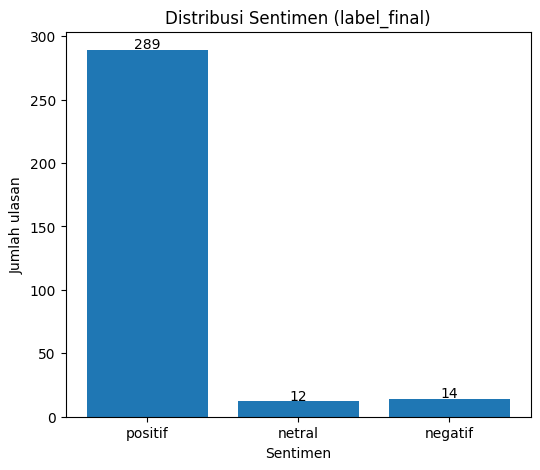

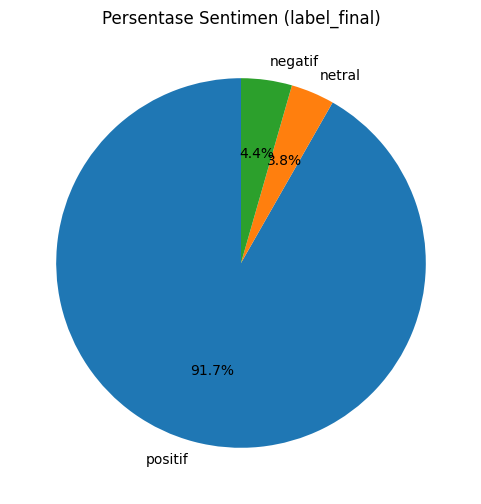

In [12]:
import matplotlib.pyplot as plt

# Distribusi label_final
counts = df_text['label_final'].value_counts().reindex(['positif','netral','negatif']).fillna(0)
plt.figure(figsize=(6,5))
plt.bar(counts.index, counts.values)
plt.title("Distribusi Sentimen (label_final)")
plt.xlabel("Sentimen")
plt.ylabel("Jumlah ulasan")
for i,v in enumerate(counts.values):
    plt.text(i, v+1, str(int(v)), ha='center')
plt.show()

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Persentase Sentimen (label_final)")
plt.show()


# *Visualisasi: frekuensi aspek & sentimen per-aspek*

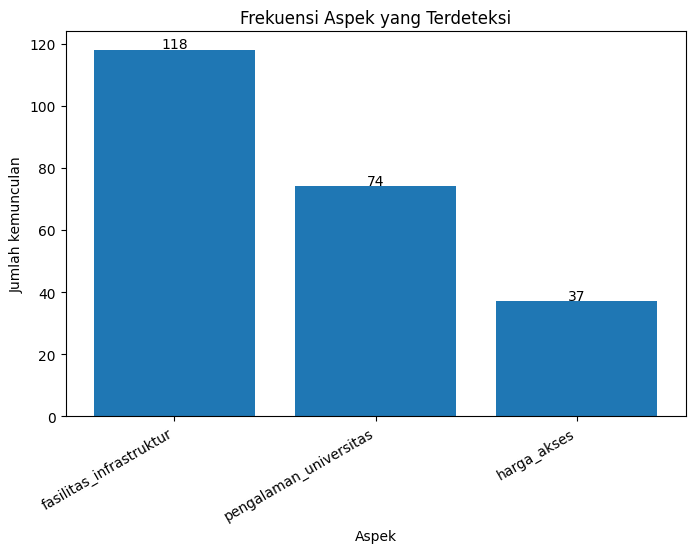

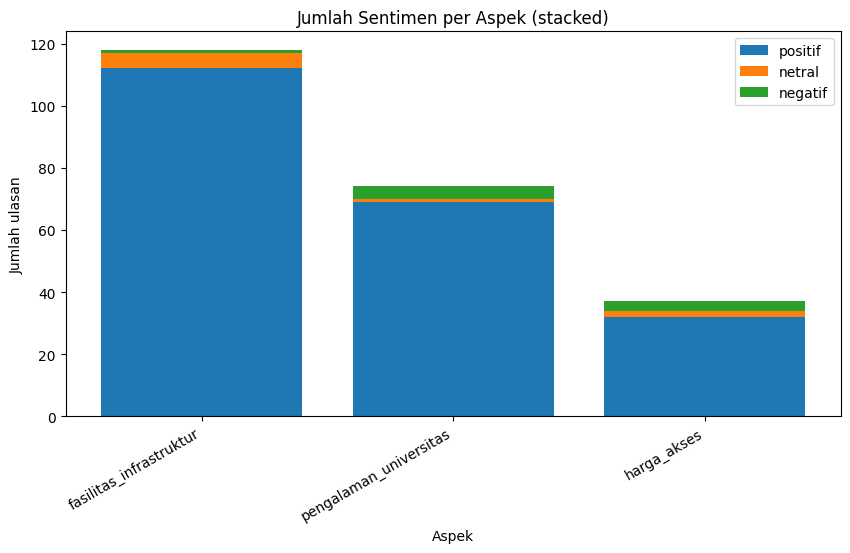

In [13]:
# Ekspand aspek (explode)
import numpy as np
df_aspect = df_text[['label_final','aspects']].copy()
df_aspect = df_aspect.explode('aspects').dropna(subset=['aspects']).reset_index(drop=True)

# Jika tidak ada aspek ditemukan, beri tahu
if df_aspect.shape[0] == 0:
    print("Tidak ada aspek terdeteksi dari keyword. Coba periksa daftar keyword atau tokens.")
else:
    # Hitung frekuensi aspek
    aspect_counts = df_aspect['aspects'].value_counts()
    plt.figure(figsize=(8,5))
    plt.bar(aspect_counts.index, aspect_counts.values)
    plt.title("Frekuensi Aspek yang Terdeteksi")
    plt.xlabel("Aspek")
    plt.ylabel("Jumlah kemunculan")
    plt.xticks(rotation=30, ha='right')
    for i,v in enumerate(aspect_counts.values):
        plt.text(i, v+0.5, str(int(v)), ha='center')
    plt.show()

    # Sentimen per aspek (stacked counts)
    aspects = aspect_counts.index.tolist()
    sentiment_order = ['positif','netral','negatif']
    data = []
    for a in aspects:
        sub = df_aspect[df_aspect['aspects']==a]
        c = sub['label_final'].value_counts().reindex(sentiment_order).fillna(0).astype(int).values
        data.append(c)
    data = np.array(data).T  # shape (3, n_aspects)

    plt.figure(figsize=(10,5))
    bottom = np.zeros(len(aspects))
    for i, s in enumerate(sentiment_order):
        plt.bar(aspects, data[i], bottom=bottom, label=s)
        bottom += data[i]
    plt.title("Jumlah Sentimen per Aspek (stacked)")
    plt.xlabel("Aspek")
    plt.ylabel("Jumlah ulasan")
    plt.xticks(rotation=30, ha='right')
    plt.legend()
    plt.show()

# *Inspect: contoh salah satu kasus conflict & contoh per label*

In [14]:
# Contoh dimana label teks dan stars berbeda (conflict)
conflicts = df_text[df_text['conflict_label']].head(10)
print("Beberapa contoh conflict (text vs star):")
display(conflicts[['text','stars','weak_label_text','weak_label_star','label_final']])

# Contoh per kelas label_final
print("\nContoh per label_final:")
for lab in ['positif','netral','negatif']:
    sample = df_text[df_text['label_final']==lab].head(3)
    print(f"\n--- {lab} ---")
    display(sample[['text','stars','weak_label_text','weak_label_star']])


Beberapa contoh conflict (text vs star):


,text,stars,weak_label_text,weak_label_star,label_final
0,Kampus keren. Sayang sempit banget. Buat parki...,5,netral,positif,positif
2,satpam malas tidak mau membantu mahasiswa untu...,1,netral,negatif,negatif
3,Terakreditasi UNGGUL di tahun 2025,5,netral,positif,positif
4,Dosen yg namanya Rasiman dan Widya kalo ngasih...,1,netral,negatif,negatif
5,My first University,5,netral,positif,positif
7,Adem,5,netral,positif,positif
8,Yang dulu IKIP PGRI Semarang sekarang berubah ...,5,netral,positif,positif
10,kampuss terbaikkk the besttt,5,netral,positif,positif
11,"Bener-bener bermakna, kangen banget UPGRIS",5,netral,positif,positif
16,Mahasiswa ceweknya ga ramah suka misuh2,1,positif,negatif,positif



Contoh per label_final:

--- positif ---


,text,stars,weak_label_text,weak_label_star
0,Kampus keren. Sayang sempit banget. Buat parki...,5,netral,positif
1,Kalian harus masup UPGRIS karena:\n1. SIOMAY D...,5,positif,positif
3,Terakreditasi UNGGUL di tahun 2025,5,netral,positif



--- netral ---


,text,stars,weak_label_text,weak_label_star
63,"Masjidnya tak ad wc,,",3,netral,netral
68,Sangat sangat nyaman,3,netral,netral
72,Kampusnya sangat Bagus\nTapi SeCuritinya Payah...,3,netral,netral



--- negatif ---


,text,stars,weak_label_text,weak_label_star
2,satpam malas tidak mau membantu mahasiswa untu...,1,netral,negatif
4,Dosen yg namanya Rasiman dan Widya kalo ngasih...,1,netral,negatif
13,"TU nya perlu dididik lagi, gak bisa membedakan...",2,negatif,negatif


# *Kata-kata yang Sering Muncul dalam Data (untuk memperkaya keyword ABSC)*

🔹 30 Kata yang paling sering muncul:

kampus          -> 103
tempat          -> 48
semarang        -> 42
upgris          -> 38
ada             -> 38
bagus           -> 34
universitas     -> 32
sangat          -> 32
kuliah          -> 29
mahasiswa       -> 28
baik            -> 26
pgri            -> 26
gedung          -> 26
guru            -> 26
didik           -> 24
bisa            -> 22
banyak          -> 22
nyaman          -> 22
kota            -> 22
bersih          -> 21
luas            -> 18
parkir          -> 16
sini            -> 16
ilmu            -> 16
fasilitas       -> 15
tengah          -> 15
bagi            -> 15
buat            -> 14
jadi            -> 14
ramah           -> 14


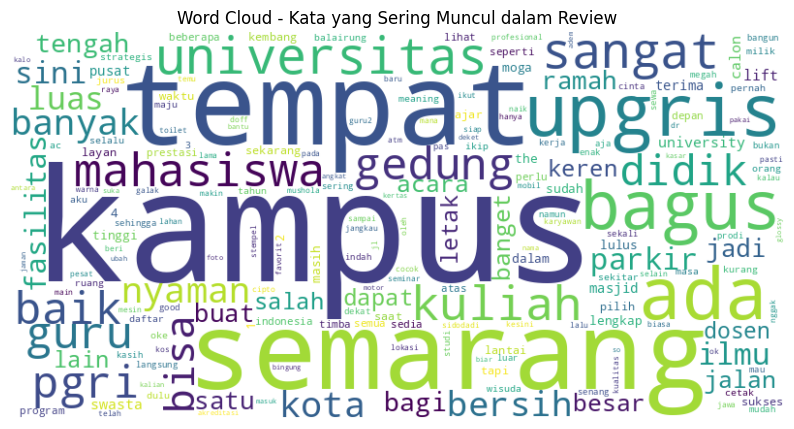

In [16]:
# --- FREQUENCY ANALYSIS UNTUK KATA YANG SERING MUNCUL ---

from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Gabungkan semua teks yang sudah di-preprocessing
# Gunakan df_text yang berisi kolom 'tokens'
all_tokens = [token for tokens in df_text['tokens'] for token in tokens if isinstance(tokens, list)]

# Hitung frekuensi
word_freq = Counter(all_tokens)
common_words = word_freq.most_common(30)
print("🔹 30 Kata yang paling sering muncul:\n")
for w, f in common_words:
    print(f"{w:<15} -> {f}")

# WordCloud untuk visualisasi
plt.figure(figsize=(10,6))
wc = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud - Kata yang Sering Muncul dalam Review")
plt.show()

# *manual labeling gold set*

In [17]:
import pandas as pd

df = pd.read_csv('/content/dataset_review_gmaps_preprocessed_ABSC.csv')
df = df[['text', 'clean']]  # ambil kolom penting
df = df.dropna(subset=['clean'])
display(df.head())

,text,clean
0,Kampus keren. Sayang sempit banget. Buat parki...,kampus keren sayang sempit banget buat parkir ...
1,Kalian harus masup UPGRIS karena:\n1. SIOMAY D...,kalian harus masup upgris karena 1 siomay deke...
2,satpam malas tidak mau membantu mahasiswa untu...,satpam malas tidak mau membantu mahasiswa untu...
3,Terakreditasi UNGGUL di tahun 2025,terakreditasi unggul di tahun 2025
4,Dosen yg namanya Rasiman dan Widya kalo ngasih...,dosen yg namanya rasiman dan widya kalo ngasih...


In [18]:
df['label_manual'] = ''


In [19]:
df.to_csv('/content/dataset_for_labeling.csv', index=False)
print("✅ File siap untuk dilabeli manual: dataset_for_labeling.csv")


✅ File siap untuk dilabeli manual: dataset_for_labeling.csv


# *TAHAP: FEATURE EXTRACTION + SVM COMPARISON*

In [21]:
# --- FEATURE EXTRACTION + SVM CLASSIFICATION ---
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load hasil preprocessing (pastikan file ini sudah dibuat di tahap sebelumnya)
df = pd.read_csv('/content/dataset_preprocessed_ABSC.csv')

# Pastikan tidak ada nilai kosong
df = df.dropna(subset=['clean', 'label_final'])
print("Jumlah data yang digunakan:", len(df))
print(df['label_final'].value_counts())


Jumlah data yang digunakan: 310
label_final
positif    285
negatif     13
netral      12
Name: count, dtype: int64


# *TF-IDF Vectorizator*
* Kita pisahkan data untuk melatih dan menguji model (rasio 80:20).

In [22]:
# TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf.fit_transform(df['clean'])
y = df['label_final']

# Split data train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Ukuran data latih:", X_train.shape)
print("Ukuran data uji:", X_test.shape)


Ukuran data latih: (248, 3964)
Ukuran data uji: (62, 3964)


# *Latih SVM dengan 4 Jenis Kernel*


===== Training SVM dengan kernel: LINEAR =====
Akurasi: 0.9194
              precision    recall  f1-score   support

     negatif       0.00      0.00      0.00         3
      netral       0.00      0.00      0.00         2
     positif       0.92      1.00      0.96        57

    accuracy                           0.92        62
   macro avg       0.31      0.33      0.32        62
weighted avg       0.85      0.92      0.88        62



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


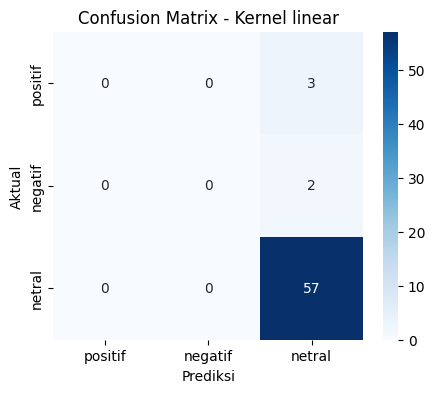


===== Training SVM dengan kernel: RBF =====
Akurasi: 0.9194
              precision    recall  f1-score   support

     negatif       0.00      0.00      0.00         3
      netral       0.00      0.00      0.00         2
     positif       0.92      1.00      0.96        57

    accuracy                           0.92        62
   macro avg       0.31      0.33      0.32        62
weighted avg       0.85      0.92      0.88        62



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


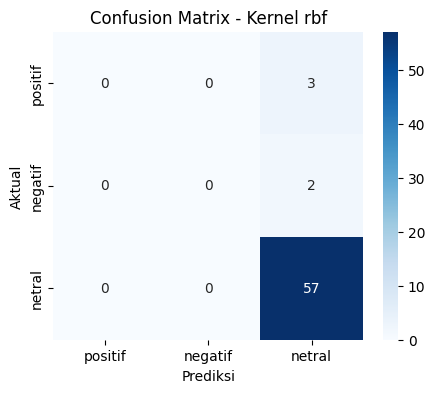


===== Training SVM dengan kernel: POLY =====
Akurasi: 0.9194
              precision    recall  f1-score   support

     negatif       0.00      0.00      0.00         3
      netral       0.00      0.00      0.00         2
     positif       0.92      1.00      0.96        57

    accuracy                           0.92        62
   macro avg       0.31      0.33      0.32        62
weighted avg       0.85      0.92      0.88        62



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


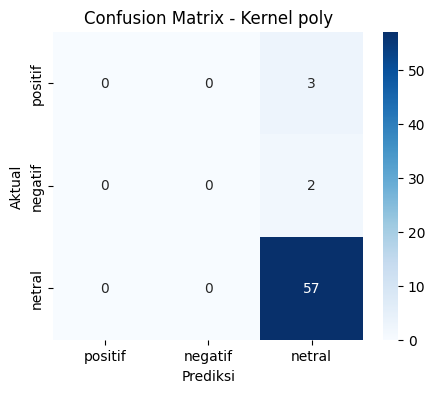


===== Training SVM dengan kernel: SIGMOID =====
Akurasi: 0.9194
              precision    recall  f1-score   support

     negatif       0.00      0.00      0.00         3
      netral       0.00      0.00      0.00         2
     positif       0.92      1.00      0.96        57

    accuracy                           0.92        62
   macro avg       0.31      0.33      0.32        62
weighted avg       0.85      0.92      0.88        62



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


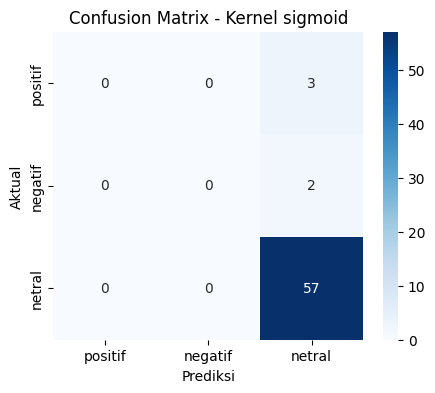

In [23]:
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
results = []

for kernel in kernels:
    print(f"\n===== Training SVM dengan kernel: {kernel.upper()} =====")
    model = SVC(kernel=kernel, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    results.append((kernel, acc))

    print(f"Akurasi: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
                xticklabels=df['label_final'].unique(), yticklabels=df['label_final'].unique())
    plt.title(f'Confusion Matrix - Kernel {kernel}')
    plt.xlabel('Prediksi')
    plt.ylabel('Aktual')
    plt.show()


# *Visualisasi Perbandingan Akurasi Tiap Kernel*

/tmp/ipython-input-1013563729.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Kernel', y='Accuracy', palette='viridis')


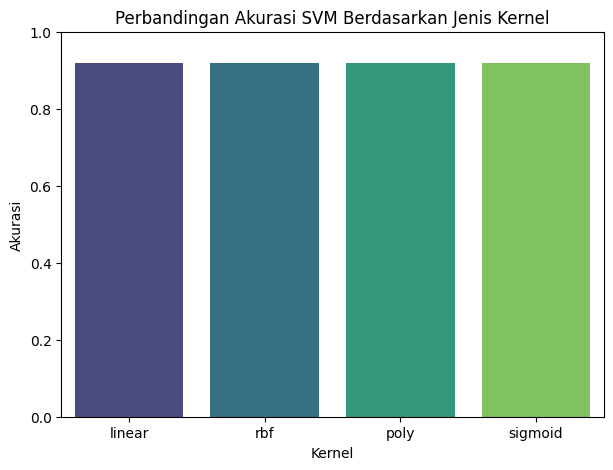


Hasil Perbandingan Akurasi:
    Kernel  Accuracy
0   linear  0.919355
1      rbf  0.919355
2     poly  0.919355
3  sigmoid  0.919355


In [32]:
# Tampilkan hasil akurasi dalam bentuk bar chart
results_df = pd.DataFrame(results, columns=['Kernel', 'Accuracy'])

plt.figure(figsize=(7,5))
sns.barplot(data=results_df, x='Kernel', y='Accuracy', palette='viridis')
plt.title('Perbandingan Akurasi SVM Berdasarkan Jenis Kernel')
plt.ylabel('Akurasi')
plt.ylim(0, 1)
plt.show()

print("\nHasil Perbandingan Akurasi:")
print(results_df)


# *Tahap 4 — Analisis & Visualisasi ABSC (Aspect-Based Sentiment Classification)*

* Mengetahui aspek apa yang paling banyak disebut (fasilitas, pengalaman, harga)

* Melihat sentimen per aspek (positif / negatif / netral)

* Membuat grafik ringkas dan menarik (bar chart, pie chart, heatmap)

*Muat Data ABSC*

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- LOAD DATA ---
df = pd.read_csv('/content/dataset_preprocessed_ABSC.csv')

# --- PENYESUAIAN KOLOM SESUAI DATA KAMU ---
# Ganti nama kolom 'aspects' jadi 'aspek_ditemukan' agar konsisten dengan kode visualisasi
df = df.rename(columns={'aspects': 'aspek_ditemukan'})

# Isi nilai kosong untuk kolom penting
df['aspek_ditemukan'] = df['aspek_ditemukan'].fillna('Tidak Terdeteksi')
df['label_final'] = df['label_final'].fillna('netral')

# --- INFO DASAR ---
print("Jumlah total ulasan:", len(df))
print("\nKolom tersedia:", df.columns.tolist())
print("\nDistribusi aspek:")
print(df['aspek_ditemukan'].value_counts())
print("\nDistribusi label sentimen:")
print(df['label_final'].value_counts())


Jumlah total ulasan: 315

Kolom tersedia: ['title', 'url', 'stars', 'name', 'reviewUrl', 'text', 'clean', 'tokens', 'aspek_ditemukan', 'weak_label_text', 'weak_label_star', 'label_agree_text_star', 'label_final', 'conflict_label']

Distribusi aspek:
aspek_ditemukan
[]                                                                      146
['fasilitas_infrastruktur']                                              73
['pengalaman_universitas']                                               41
['fasilitas_infrastruktur', 'pengalaman_universitas']                    18
['fasilitas_infrastruktur', 'harga_akses']                               16
['fasilitas_infrastruktur', 'pengalaman_universitas', 'harga_akses']     11
['harga_akses']                                                           6
['pengalaman_universitas', 'harga_akses']                                 4
Name: count, dtype: int64

Distribusi label sentimen:
label_final
positif    290
negatif     13
netral      12
Name: count, dt

# *Analisis Jumlah Ulasan per Aspek*








/tmp/ipython-input-3838257031.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='aspek_ditemukan', order=df['aspek_ditemukan'].value_counts().index, palette='viridis')


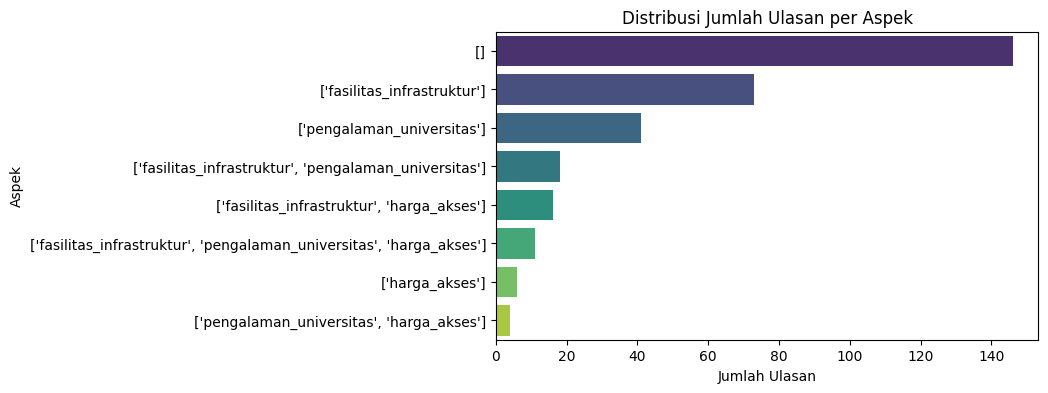

In [25]:
plt.figure(figsize=(7,4))
sns.countplot(data=df, y='aspek_ditemukan', order=df['aspek_ditemukan'].value_counts().index, palette='viridis')
plt.title('Distribusi Jumlah Ulasan per Aspek')
plt.xlabel('Jumlah Ulasan')
plt.ylabel('Aspek')
plt.show()


# *Analisis Distribusi Sentimen Umum*

/tmp/ipython-input-1892139393.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label_final', palette='Set2')


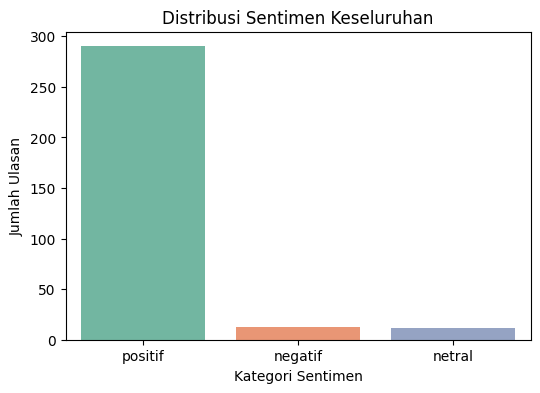

In [26]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='label_final', palette='Set2')
plt.title('Distribusi Sentimen Keseluruhan')
plt.xlabel('Kategori Sentimen')
plt.ylabel('Jumlah Ulasan')
plt.show()


# *Distribusi Sentimen per Aspek*



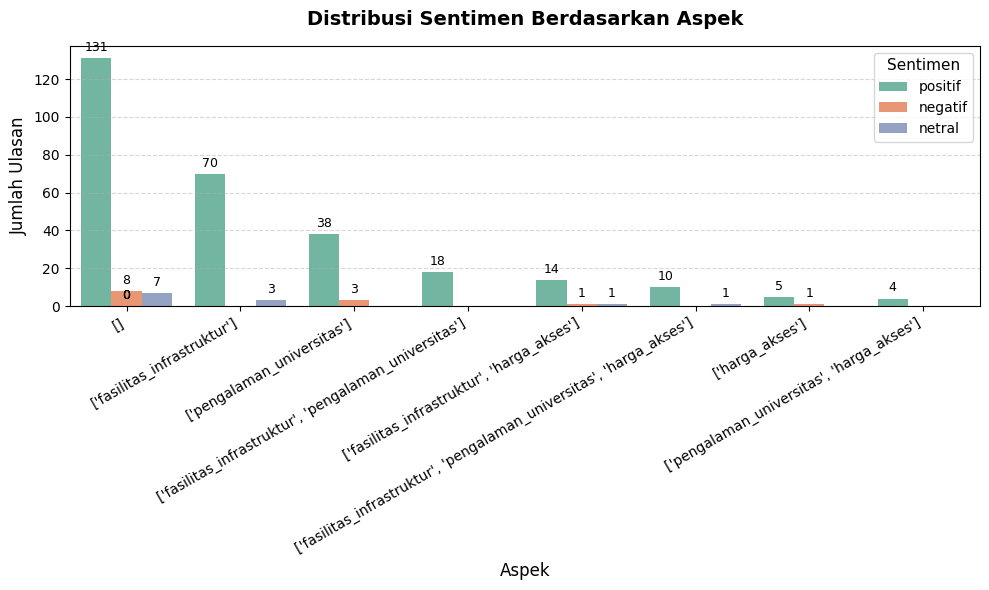

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
ax = sns.countplot(
    data=df,
    x='aspek_ditemukan',
    hue='label_final',
    palette='Set2',
    order=df['aspek_ditemukan'].value_counts().index  # urutkan berdasarkan jumlah terbanyak
)

# --- Tambahan untuk mempercantik ---
plt.title('Distribusi Sentimen Berdasarkan Aspek', fontsize=14, weight='bold', pad=15)
plt.xlabel('Aspek', fontsize=12)
plt.ylabel('Jumlah Ulasan', fontsize=12)
plt.xticks(rotation=30, ha='right', fontsize=10)  # miringkan teks agar tidak tumpuk
plt.legend(title='Sentimen', title_fontsize=11, fontsize=10)
plt.tight_layout()  # biar tidak kepotong tepi
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Tampilkan angka di atas bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 3),
                textcoords='offset points')

plt.show()


# *Heatmap Aspek vs Sentimen*

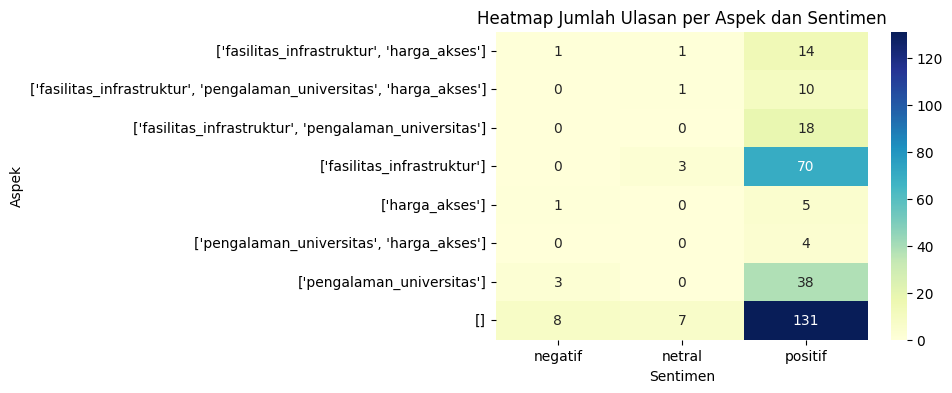

label_final                                         negatif  netral  positif
aspek_ditemukan                                                             
['fasilitas_infrastruktur', 'harga_akses']                1       1       14
['fasilitas_infrastruktur', 'pengalaman_univers...        0       1       10
['fasilitas_infrastruktur', 'pengalaman_univers...        0       0       18
['fasilitas_infrastruktur']                               0       3       70
['harga_akses']                                           1       0        5
['pengalaman_universitas', 'harga_akses']                 0       0        4
['pengalaman_universitas']                                3       0       38
[]                                                        8       7      131


In [28]:
pivot = df.pivot_table(index='aspek_ditemukan', columns='label_final', aggfunc='size', fill_value=0)

plt.figure(figsize=(6,4))
sns.heatmap(pivot, annot=True, cmap='YlGnBu', fmt='d')
plt.title('Heatmap Jumlah Ulasan per Aspek dan Sentimen')
plt.xlabel('Sentimen')
plt.ylabel('Aspek')
plt.show()

print(pivot)


# *Pie Chart - Proporsi Sentimen*

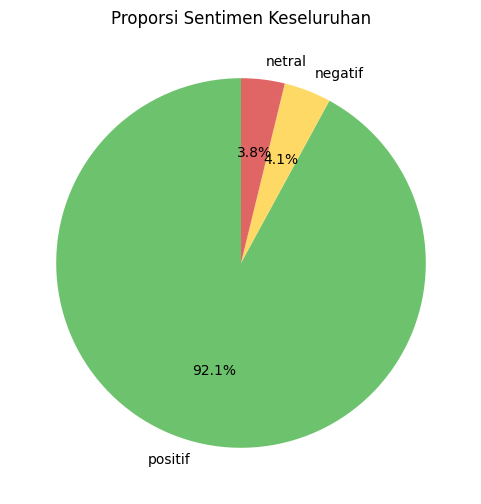

In [29]:
sentiment_counts = df['label_final'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['#6DC36D','#FFD966','#E06666'])
plt.title('Proporsi Sentimen Keseluruhan')
plt.show()


# *Laporan Analisis Otomatis*